In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For Recommendation
from surprise import Dataset, Reader, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

# Set some display options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the datasets
try:
    appliances_df = pd.read_csv("appliances.csv")
    interactions_df = pd.read_csv("interactions.csv")
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'appliances.csv' or 'interactions.csv' not found. ")
    raise

print("\n--- Appliances Data ---")
print(appliances_df.head())
print(f"\nShape: {appliances_df.shape}")
appliances_df.info()

print("\n--- Interactions Data ---")
print(interactions_df.head())
print(f"\nShape: {interactions_df.shape}")
interactions_df.info()

Datasets loaded successfully.

--- Appliances Data ---
  appliance_id                                     name        category        brand price_range  \
0       AP0000  KitchenAid Robot Vacuum Model Alpha3237    Robot Vacuum   KitchenAid         Low   
1       AP0001  Electrolux Vacuum Cleaner Model Pro3997  Vacuum Cleaner   Electrolux     Premium   
2       AP0002     Instant Pot Water Heater Model S6996    Water Heater  Instant Pot      Medium   
3       AP0003            Bosch Robot Vacuum Model X720    Robot Vacuum        Bosch     Premium   
4       AP0004         Panasonic Dishwasher Model X5485      Dishwasher    Panasonic     Premium   

                                      features  base_avg_rating  
0            Self-Charging, Mapping Technology              3.9  
1                   Canister, Robotic, Upright              3.9  
2  Storage Tank, Electric, Heat Pump, Tankless              2.7  
3            Self-Charging, Mapping Technology              4.3  
4             

In [3]:
# Check for missing values
print("Missing values in appliances_df:\n", appliances_df.isnull().sum())
print("\nMissing values in interactions_df:\n", interactions_df.isnull().sum())

# Convert timestamp to datetime (though not directly used by SVD model for training, useful for EDA/context)
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])


# check the rating scale
print("\nRating distribution:")
print(interactions_df['rating'].value_counts().sort_index())

# The 'surprise' library needs a Reader object to parse the data.
# We specify the rating_scale.
reader = Reader(rating_scale=(1, 5))

# Load data from pandas DataFrame into Surprise's Dataset format
# only need the columns for user, item, and rating for collaborative filtering
data = Dataset.load_from_df(interactions_df[['user_id', 'appliance_id', 'rating']], reader)

print("\nData loaded into Surprise Dataset format.")

Missing values in appliances_df:
 appliance_id       0
name               0
category           0
brand              0
price_range        0
features           0
base_avg_rating    0
dtype: int64

Missing values in interactions_df:
 user_id             0
appliance_id        0
interaction_type    0
rating              0
timestamp           0
dtype: int64

Rating distribution:
rating
1     7328
2     8692
3    14237
4     9728
5     4283
Name: count, dtype: int64

Data loaded into Surprise Dataset format.


--- Interactions Data Analysis ---
Number of unique users: 1000
Number of unique appliances: 200
Total interactions: 44268
Sparsity: 0.7787


C:\Users\HP\AppData\Local\Temp\ipykernel_7376\2553717205.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=interactions_df, palette="viridis")


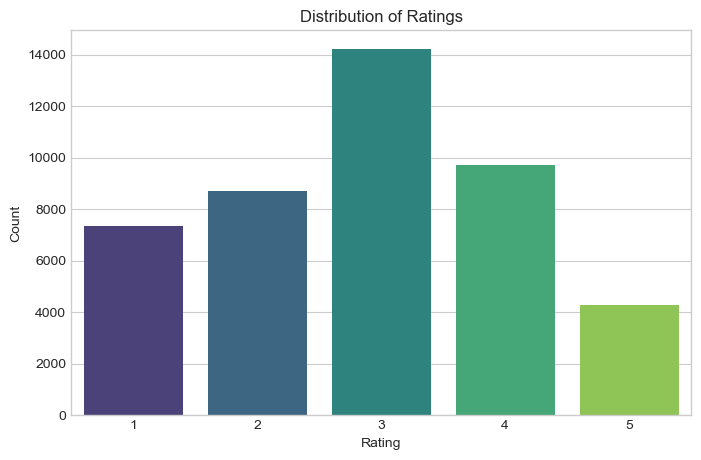

C:\Users\HP\AppData\Local\Temp\ipykernel_7376\2553717205.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='interaction_type', data=interactions_df, palette="mako", order=interactions_df['interaction_type'].value_counts().index)


count    44268.000000
mean         2.885832
std          1.205096
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64


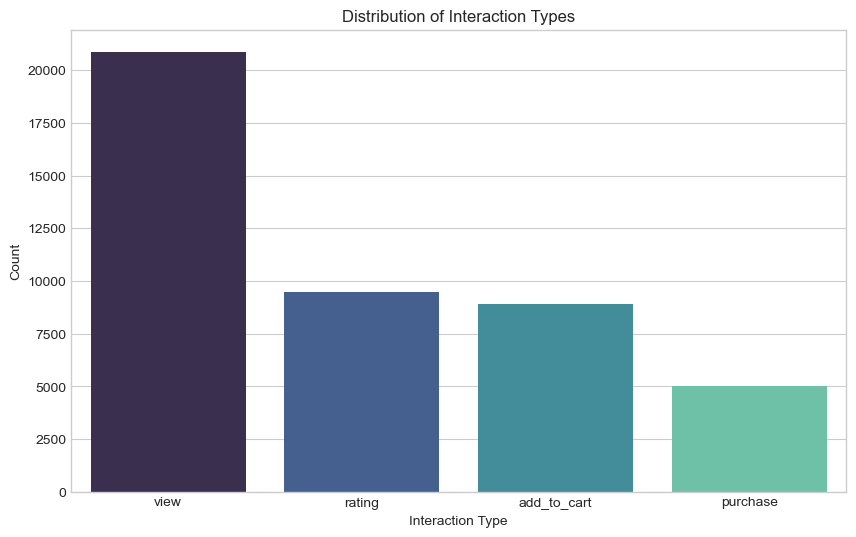

interaction_type
view           0.471582
rating         0.213676
add_to_cart    0.201161
purchase       0.113581
Name: proportion, dtype: float64


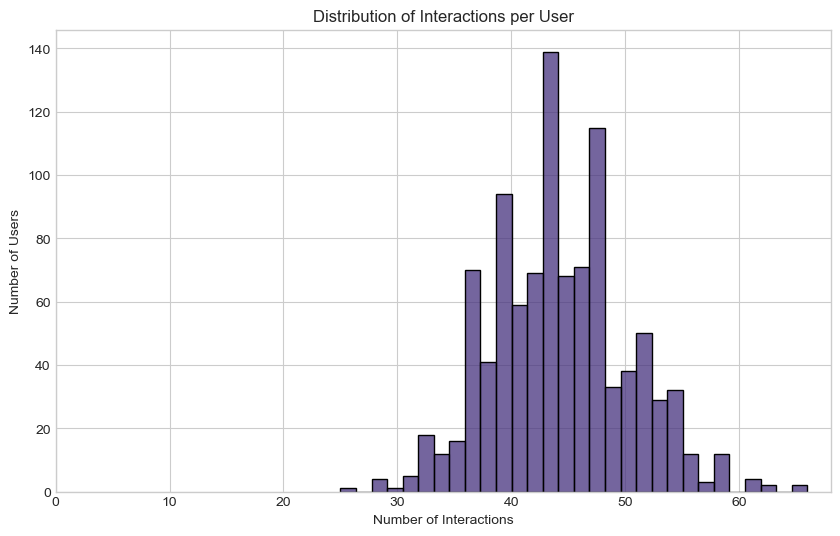


Interactions per user stats:
 count    1000.000000
mean       44.268000
std         5.945715
min        25.000000
25%        40.000000
50%        44.000000
75%        48.000000
max        66.000000
dtype: float64


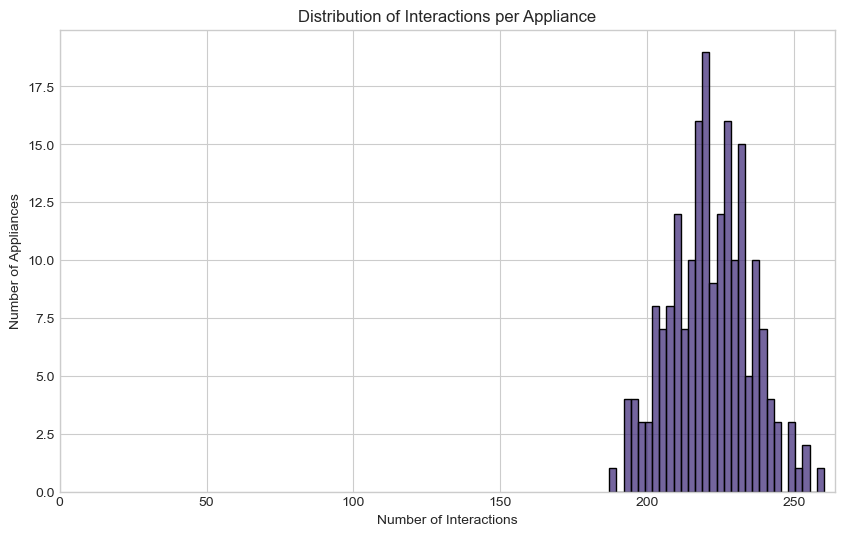


Interactions per appliance stats:
 count    200.000000
mean     221.340000
std       13.670729
min      187.000000
25%      211.750000
50%      221.000000
75%      231.000000
max      260.000000
dtype: float64

--- Top 10 Most Interacted Appliances ---
  appliance_id                                       name         category          brand  \
0       AP0010              Panasonic Toaster Model S5694          Toaster      Panasonic   
1       AP0028  GE Appliances Electric Kettle Model S6872  Electric Kettle  GE Appliances   
7       AP0145      GE Appliances Stand Mixer Model X2752      Stand Mixer  GE Appliances   
3       AP0078             KitchenAid Dryer Model Eco6964            Dryer     KitchenAid   
2       AP0052            Miele Stand Mixer Model Pro7509      Stand Mixer          Miele   
4       AP0095             Sony Air Fryer Model Alpha8060        Air Fryer           Sony   
8       AP0185                    Sharp Dryer Model X5754            Dryer          Sharp   
9 

In [4]:
print("--- Interactions Data Analysis ---")

# Number of unique users and items
n_users = interactions_df['user_id'].nunique()
n_items = interactions_df['appliance_id'].nunique()
n_interactions = len(interactions_df)
print(f"Number of unique users: {n_users}")
print(f"Number of unique appliances: {n_items}")
print(f"Total interactions: {n_interactions}")

# Sparsity of the user-item interaction matrix
sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"Sparsity: {sparsity:.4f}")

# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=interactions_df, palette="viridis")
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
print(interactions_df['rating'].describe())

# Distribution of interaction types
plt.figure(figsize=(10, 6))
sns.countplot(x='interaction_type', data=interactions_df, palette="mako", order=interactions_df['interaction_type'].value_counts().index)
plt.title('Distribution of Interaction Types')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.show()
print(interactions_df['interaction_type'].value_counts(normalize=True))


# Number of interactions per user
user_interaction_counts = interactions_df.groupby('user_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_interaction_counts, bins=30, kde=False)
plt.title('Distribution of Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.xlim(left=0)
plt.show()
print("\nInteractions per user stats:\n", user_interaction_counts.describe())

# Number of interactions per appliance
item_interaction_counts = interactions_df.groupby('appliance_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(item_interaction_counts, bins=30, kde=False)
plt.title('Distribution of Interactions per Appliance')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Appliances')
plt.xlim(left=0)
plt.show()
print("\nInteractions per appliance stats:\n", item_interaction_counts.describe())

# Most interacted/rated items 
top_n = 10
popular_items = interactions_df['appliance_id'].value_counts().nlargest(top_n).index
popular_items_details = appliances_df[appliances_df['appliance_id'].isin(popular_items)][['appliance_id', 'name', 'category', 'brand']]
print(f"\n--- Top {top_n} Most Interacted Appliances ---")
# Merge with interaction counts
popular_items_counts = interactions_df['appliance_id'].value_counts().nlargest(top_n).reset_index()
popular_items_counts.columns = ['appliance_id', 'interaction_count']
print(pd.merge(popular_items_details, popular_items_counts, on='appliance_id').sort_values(by='interaction_count', ascending=False))

In [5]:
# Split data into training and test set
# test_size=0.2 means 20% of the data is used for testing
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)

print(f"Number of ratings in trainset: {trainset.n_ratings}")
print(f"Number of ratings in testset: {len(testset)}")

# Hyperparameter Tuning with GridSearchCV 
print("\n--- Hyperparameter Tuning for SVD using GridSearchCV ---")
# Expanded param_grid for a more thorough search, but still manageable.
param_grid = {
    "n_factors": [50, 100, 150],   # Number of factors
    "n_epochs": [20, 30, 40],      # Number of epochs
    "lr_all": [0.002, 0.005, 0.01], # Learning rate
    "reg_all": [0.02, 0.05, 0.1]   # Regularization term
}

# cv=3 for 3-fold cross-validation.
# n_jobs=-1 uses all available CPU cores. joblib_verbose=1 gives some progress output.
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3, n_jobs=-1, joblib_verbose=2)

# GridSearchCV performs its own cross-validation on the 'data' object.
gs.fit(data)

# Best RMSE score from GridSearchCV
print(f"\nBest RMSE score from GridSearchCV: {gs.best_score['rmse']:.4f}")
print(f"Best MAE score from GridSearchCV: {gs.best_score['mae']:.4f}")

# Combination of parameters that gave the best RMSE score
print("Best SVD parameters for RMSE:", gs.best_params["rmse"])

# Get the best SVD model estimator based on RMSE
best_svd_model = gs.best_estimator['rmse']


print("\n--- Training the best SVD model on the designated trainset ---")
best_svd_model.fit(trainset) # Train with best parameters on our specific trainset

# Predict ratings for the testset using the best model
print("\n--- Evaluating the best SVD model on the testset ---")
predictions_best_svd = best_svd_model.test(testset)

# Compute and print RMSE and MAE for the best model
rmse_best_svd = accuracy.rmse(predictions_best_svd, verbose=True)
mae_best_svd = accuracy.mae(predictions_best_svd, verbose=True)

# Now, 'best_svd_model' is trained and ready. This will be our final model.
final_model = best_svd_model
print("\n`final_model` is now set to the SVD model tuned with GridSearchCV.")

print("\n--- For Comparison: Basic SVD model (if you want to keep its training) ---")
basic_svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42, verbose=False)
basic_svd_model.fit(trainset)
predictions_basic_svd = basic_svd_model.test(testset)
print("Basic SVD Performance (for comparison):")
accuracy.rmse(predictions_basic_svd, verbose=True)
accuracy.mae(predictions_basic_svd, verbose=True)

Number of ratings in trainset: 35414
Number of ratings in testset: 8854

--- Hyperparameter Tuning for SVD using GridSearchCV ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   18.6s finished



Best RMSE score from GridSearchCV: 1.2049
Best MAE score from GridSearchCV: 0.9856
Best SVD parameters for RMSE: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.1}

--- Training the best SVD model on the designated trainset ---

--- Evaluating the best SVD model on the testset ---
RMSE: 1.2118
MAE:  0.9934

`final_model` is now set to the SVD model tuned with GridSearchCV.

--- For Comparison: Basic SVD model (if you want to keep its training) ---
Basic SVD Performance (for comparison):
RMSE: 1.2412
MAE:  1.0211


1.0211146618021438

In [6]:
def get_top_n_recommendations(user_id, n=10, model=final_model, appliances_df=appliances_df, interactions_df=interactions_df):
    """
    Generates Top-N recommendations for a given user.
    Uses optimized prediction for SVD models by leveraging latent factors.
    Falls back to item-by-item prediction for other model types or if SVD optimization fails.
    """
    # 0. Check if user is known to the model's trainset
    try:
        if not hasattr(model, 'trainset') or model.trainset is None:
            print("Model has not been fitted yet or does not have a trainset.")
            return pd.DataFrame()
        model.trainset.to_inner_uid(user_id) # This will raise ValueError if user_id is not in trainset
    except ValueError:
        print(f"User {user_id} is not known to the model (not in the training set). Cannot generate recommendations.")
        return pd.DataFrame()
        
    # 1. Get all unique appliance IDs
    all_appliance_ids = appliances_df['appliance_id'].unique()
    
    # 2. Get appliance IDs the user has already interacted with from the original interactions_df
    interacted_appliance_ids = interactions_df[interactions_df['user_id'] == user_id]['appliance_id'].unique()
    
    # 3. Identify candidate items (items not yet interacted with by this user)
    candidate_appliance_ids = np.setdiff1d(all_appliance_ids, interacted_appliance_ids, assume_unique=True)
    
    if len(candidate_appliance_ids) == 0:
        print(f"User {user_id} has interacted with all available items or no candidate items found.")
        return pd.DataFrame()

    # 4. Predict ratings for candidate items
    predictions_data = []

    if isinstance(model, SVD):
        # Optimized approach for SVD: use latent factors and biases
        try:
            inner_user_id = model.trainset.to_inner_uid(user_id)
            user_factors = model.pu[inner_user_id]
            user_bias = model.bu[inner_user_id]
            global_mean = model.trainset.global_mean

            for appliance_id in candidate_appliance_ids:
                try:
                    inner_item_id = model.trainset.to_inner_iid(appliance_id)
                    item_factors = model.qi[inner_item_id]
                    item_bias = model.bi[inner_item_id]
                    
                    # SVD prediction formula: global_mean + user_bias + item_bias + dot(user_factors, item_factors)
                    estimated_rating = global_mean + user_bias + item_bias + np.dot(user_factors, item_factors)
                    predictions_data.append({'appliance_id': appliance_id, 'predicted_rating': estimated_rating})
                except ValueError: 
                    
                    pred_obj = model.predict(uid=user_id, iid=appliance_id)
                    predictions_data.append({'appliance_id': appliance_id, 'predicted_rating': pred_obj.est})
                    
        except Exception as e:
            print(f"Optimized SVD prediction failed for user {user_id}: {e}. Falling back to item-by-item prediction.")
            # Fallback to item-by-item prediction
            predictions_data = [] # Clear previous attempts
            for appliance_id in candidate_appliance_ids:
                pred = model.predict(uid=user_id, iid=appliance_id)
                predictions_data.append({'appliance_id': appliance_id, 'predicted_rating': pred.est})
    else:
        # Original item-by-item prediction for non-SVD models
        for appliance_id in candidate_appliance_ids:
            pred = model.predict(uid=user_id, iid=appliance_id)
            predictions_data.append({'appliance_id': appliance_id, 'predicted_rating': pred.est})
        
    if not predictions_data:
        print(f"No predictions could be generated for user {user_id} from candidate items.")
        return pd.DataFrame()

    # 5. Rank items
    recommendations_df = pd.DataFrame(predictions_data)
    recommendations_df = recommendations_df.sort_values(by='predicted_rating', ascending=False)
    
    # 6. Select Top-N and merge with appliance details
    top_n_df = recommendations_df.head(n)
    top_n_df = pd.merge(top_n_df, appliances_df[['appliance_id', 'name', 'category', 'brand']], on='appliance_id', how='left') # Select only needed columns
    
    return top_n_df[['appliance_id', 'name', 'category', 'brand', 'predicted_rating']]

# Test the recommendation function
print("\n--- Testing Recommendation Function ---")

# Ensure the trainset (used by final_model) is available for user ID mapping
if hasattr(final_model, 'trainset') and final_model.trainset:
    # Pick a user for testing. Try one with many interactions first.
    potential_test_users = interactions_df['user_id'].value_counts().index.tolist()
    test_user_id = None
    for u_id in potential_test_users:
        try:
            final_model.trainset.to_inner_uid(u_id)
            test_user_id = u_id
            break # Found a user present in the trainset
        except ValueError:
            continue
    
    if test_user_id is None and final_model.trainset.n_users > 0:
        # Fallback: pick the first user from the trainset if no high-interaction user was found in it
        test_user_id = final_model.trainset.to_raw_uid(0) 
        print(f"Fallback: Testing with user {test_user_id} from trainset.")
    elif test_user_id is None:
        print("Could not find any user from interactions_df in the model's trainset, or trainset is empty.")
        
else:
    print("Final model has not been trained or has no trainset. Cannot test recommendation function.")
    test_user_id = None # Ensure it's None if we can't proceed

if test_user_id:
    print(f"\nRecommendations for User: {test_user_id}")
    user_recommendations = get_top_n_recommendations(test_user_id, n=5, model=final_model)

    if not user_recommendations.empty:
        print(user_recommendations)
    else:
        print(f"No recommendations generated for user {test_user_id}.")

    # What did this user rate highly in the past
    print(f"\n--- User {test_user_id}'s Past High Ratings (for context) ---")
    user_past_interactions = interactions_df[interactions_df['user_id'] == test_user_id].sort_values(by='rating', ascending=False)
    user_past_interactions_details = pd.merge(user_past_interactions, appliances_df, on='appliance_id', how='left')
    print(user_past_interactions_details[['name', 'category', 'brand', 'rating']].head(10))
else:
    print("No test user ID available to generate recommendations.")


--- Testing Recommendation Function ---

Recommendations for User: U0509
  appliance_id                                 name         category    brand  predicted_rating
0       AP0021      Maytag Dishwasher Model Eco3090       Dishwasher   Maytag          3.574219
1       AP0169        Haier Robot Vacuum Model X778     Robot Vacuum    Haier          3.527358
2       AP0149        Haier Microwave Model Max7481        Microwave    Haier          3.519006
3       AP0130  Kenmore Air Conditioner Model X9731  Air Conditioner  Kenmore          3.499149
4       AP0060           Bosch Toaster Model Pro721          Toaster    Bosch          3.478604

--- User U0509's Past High Ratings (for context) ---
                                        name         category       brand  rating
0           KitchenAid Blender Model Eco3824          Blender  KitchenAid       5
1               LG Coffee Maker Model Eco832     Coffee Maker          LG       5
2            Whirlpool Toaster Model Eco7207      